In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools

In [1114]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                x_Y = U + 3*df.groupby(["indiv"]).A.mean()
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [3]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [4]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    columns = ["time", "gamma_0", "gamma_1", "gamma_2", "gamma_3", "gamma_4", \
              "gamma_5", "gamma_6"]
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model_df = pd.DataFrame(columns = columns)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "A_1"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + \
                         [L1_model.params[i] for i in range(0,2)] + ["Nan"] + \
                         ["Nan"] + [L1_model.params[2]] + ["Nan"] + ["Nan"], \
                         index = columns).transpose(), ignore_index=True)
        elif ii == 2: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] \
                          for i in range(0,3)] + ["Nan"] + [L1_model.params[i] for i \
                          in range(3,5)] + ["Nan"], index = columns).transpose(), \
                          ignore_index=True)
        else: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] for \
                          i in range(0,7)], index = columns).transpose(), \
                          ignore_index=True)
    return(L1_model_df)

In [196]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    columns = ["time", "zeta_0", "zeta_1", "zeta_2", "zeta_3", "zeta_4"]
    train_columns = ["L1", "L1_1", "A_1", "A_2"]
    A_model_df = pd.DataFrame(columns = columns)

    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,2)] + [float("nan")] + [float("nan")] +[float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        elif ii == 1: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "A_1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,4)] + [float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        else: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[train_columns]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,5)],index = columns).transpose(), \
                         ignore_index=True)
    return(A_model_df)


In [379]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    values[1] = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    p_v = np.exp(values[1])/(1+np.exp(values[1]))
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    values[2] = np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = (np.exp(values[2])/(1+np.exp(values[2]))) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        values[jj] = np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = (np.exp(values[jj])/(1+np.exp(values[jj]))) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [709]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [619]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [559]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [631]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [713]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [1117]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect_df = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

results_g_form_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

alpha_model_right = [False]*12
s_model_right = [False]*12

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]

    # df = df.iloc[:,0:12]
    for kk in range(0,max_time+1):
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
        
    [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    results_effect_df.loc[len(results_effect_df)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
results_effect_df.to_csv("W_EFFECT_RESULTS")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.531326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691481


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.483786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.538948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691694
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691532
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689929


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.519641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692009


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.552176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688588


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.494646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686765


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.505741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689440


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.522692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691762
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688821


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.487445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691306


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.497864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684659


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.522792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.511417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691084
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.479324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690703

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.516279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.514444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691750
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691464
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.510741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692177
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.495607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691758
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691765
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691824
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.506654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.525213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.514122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692015
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.524820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691292
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.524504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691516
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.504654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.504533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678219

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.502053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691244

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.498684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.484974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690345
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692337
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.518725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.513338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690648
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692040
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.513249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.505051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691403

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.540733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.531597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.505326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691831
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691118

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.548841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.508760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691802

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.535106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.515106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.512955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.515666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.512441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692054
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690023

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.528201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.505709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691847
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.515555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690220

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.515651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689424

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.518752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691329
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.545721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.515639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691682
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689534

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.524111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691480
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.521316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.515907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691435
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.512357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692304
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.520746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692416
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691777
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.484172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691977
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.500571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.533741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692075
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.536439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691672
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691406
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.517519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691750
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690525

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.507015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691480
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.500714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.490882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691523
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689743

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.528862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692374
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.512536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.496899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686092

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.520386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.508097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691195
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692217
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.503714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692428
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691820
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692534

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.536165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.509511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690645

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.538185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692166
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688110

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.538196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691511

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.502366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689911

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.532011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.495040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.505394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.524478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.502095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.528073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691614
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.537974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689236

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.463083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.506255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692002
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691900
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.517805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691986
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.516474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.501149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.551806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.510712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.530859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692176
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.499380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690522
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.520524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691613
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692234
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.539060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689635

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.521876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.510247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692326
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.528869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692364
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691730
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.493277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.511707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691663
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689425

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.500422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.525353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.544614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.549289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.515645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692065
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690213

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.504069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.488135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.490258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.477753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.514634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692343
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692514
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.517559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.516826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.491713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691803
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.517729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692233
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.510384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.513834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.502506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.508574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691286
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691420
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.520383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692665
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.527467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691630
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.518876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691578
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692256
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.534066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.527596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.512337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68375

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.492421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.487867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.485617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691549
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.515577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692296
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68947

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.493497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68966

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.520570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.543608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.500514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68699

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.499019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.515727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.536385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.507123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68797

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.488290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692191
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69191

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.516387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68588

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.507793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.479260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.507834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691538
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.488322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692248
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.529350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.524019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691218
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.504592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.491714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.503154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68783

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.496681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68868

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.521793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68651

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.497304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.495127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691726
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68962

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.489644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692250
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.504859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692180
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69099

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.514486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691837
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691971
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691498
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.492941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69270

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.510602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692013
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.492229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.541837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.523903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.511263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.497761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691694
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.530954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691445
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.511327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691287
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.512184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.533373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.514268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691858
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.496108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.540778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.539766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.513838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68966

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.512731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692690
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.515019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692546
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.489907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.511844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691566
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.506758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.515060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69185

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.479309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.536265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691417
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691807
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68929

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.518630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.510833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68972

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.551363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.532078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.519124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.533104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.475540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.507826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691624
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68741

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.508281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68582

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.513268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.505403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.521736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.524141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68935

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.545629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.497202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691729
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.506987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.492092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.497326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692715
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.540779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.506974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.536547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.521688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.493431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.503690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.512950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.494966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692790
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.542973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691779
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.523677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.483016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.544933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.515366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691991
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.501114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692000
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.537071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.500800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.497283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69064

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.513423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.484283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.500362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691550
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.534875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.524045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.534532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692415
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.486109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.494769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692415
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.496284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.501519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692024
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.540392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.536960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.524413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691453
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691687
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.511912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692038
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.502112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.482490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692018
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.499896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.497442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692321
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.500173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691729
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.507621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.566328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.493516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.521523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.507256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691542
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68831

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.512490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69021

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.511992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.541085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.518520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692512
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.494514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692497
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.487569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.525141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691714
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692030
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.546307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.512539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.505946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691808
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.501242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.491430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.476947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.492809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691971
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691511
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68219

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.509232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.508553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.525033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.513950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.534110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.509446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.495217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.520745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68802

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.503551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691883
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.495486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691706
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.502657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.512526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691200
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.515924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.514281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.490394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.505943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.528725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692645
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.484208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.488528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692402
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.503269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68959

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.542999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.507067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.517472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691761
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.551906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692032
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692560
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.527867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691865
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691349
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.541000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.526835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.514531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.519088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.522408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.512341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.525102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691763
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.526715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692623
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691528
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.515535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691831
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.503424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692577
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.513649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.525220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69046

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.510692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691891
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.482675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.530763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692210
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.513209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.537745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.522904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.514427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.533710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.540748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.527922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.538127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68472

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.522406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.498894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692475
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68998

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.508445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69153

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.497521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692025
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.530721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691668
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.509306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691655
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69245

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.532136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.497594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.501552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68676

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.510005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.509192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691538
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.492107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691158
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68761

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.514641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69108

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.518938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.522765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.538601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692189
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.523272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.490881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.530236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.534555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691693
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692033
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68802

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.514201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.506211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691500
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.527376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691831
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.542416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.493480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.521980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.510094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690762
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692036
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.501868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.527051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692519
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691566
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.487265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691902
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68947

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.513345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692359
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.524696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691611
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.520357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.514829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68867

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.534252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69119

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.494040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.502223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692606
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.479326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691778
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.503450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692157
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.523014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.485321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.532216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692211
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.501343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691522
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692042
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691559
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.512176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.547466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691050
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.518625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.500971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690513
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.524795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.533725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.506027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.500998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692305
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.530267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691520
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68785

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.521723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691834
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691927
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.490701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691336
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.530962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.534424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.484918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.507690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691264
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.489609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.493297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.502112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.533894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.507705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691751
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.502229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692255
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.533480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.504572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.515645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.483991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.501575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69119

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.483032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691693
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.535359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.552046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68563

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.492865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.509429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692352
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69064

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.523606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.499196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692403
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69100

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.510727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.503688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692017
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.517354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691609
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.505455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.498139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691826
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.490393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691343
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.509733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.516422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692372
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.520091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.496861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692002
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.516389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.531573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.493004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.487057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692779
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.524055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.536756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.506135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.504052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.503916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.524386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691909
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691645
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69191

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.506966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.531083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.501630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691514
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691856
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.500193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692567
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.509293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.529922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.500891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692576
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.524964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691679
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.475367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.527358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692149
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692509
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69073

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.527521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.491984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.522966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.537371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.510505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.507034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691974
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692579
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.507151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.468815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691941
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691526
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.493474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.474316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.516376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.498648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.497457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.516077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69176

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.499943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690870
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.490809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.530586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691552
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691835
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.492434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691074
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.524359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691309
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.492210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692546
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.507400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.509367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.524120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692173
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.511842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.529270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68645

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.515699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692310
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69141

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.515228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.518749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.519497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.495301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690856
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68992

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.525819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.507754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.505964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692764
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68796

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.544813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691504
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.526186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692016
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.491539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.497412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.523635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.500796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.490544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.534665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.528152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691395
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691804
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.493294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691552
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.511183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.524594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691509
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692286
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691743
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68947

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.487667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.491914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691823
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68548

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.494015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691588
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.480629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.526505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.536326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68938

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.537795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68409

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.499182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.524472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692167
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68733

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.484355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692417
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.530560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.532028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.501593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691795
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.491490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.487667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692193
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.521229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691443
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.536747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68853

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.525208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.524416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.516075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691708
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.513184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.495945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.496697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691064
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.487136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692675
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.510369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.522572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68604

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.493878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.472083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.504837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691852
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.501862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691702
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.524449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.518955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.504162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.508868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.503939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692493
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.501450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.510632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.547635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690830
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691272
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.517323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.520221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690566
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692210
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.541281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.480074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692383
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.527613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.516505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691589
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68725

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.523998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691950
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.501302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.521655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692048
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.496354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68908

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.542371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.486871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69165

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.508498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.516772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.519685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.517063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.512572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.488397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691728
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.521802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.503228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.515484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.518914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.486627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691928
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692001
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.533405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692491
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692483
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.529957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692291
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.556880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.509611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.532453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.523552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691462
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691856
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.504160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691935
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.534011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691737
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.482692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.506988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.509559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691470
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691575
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691189
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.500637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.549356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691657
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.507105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691727
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68908

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.498346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.482690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691916
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691358
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69052

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.542021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691709
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.532404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.501070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.510482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69169

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.511790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.541892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692585
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.508801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.501072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691673
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.533827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.517665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.489587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.480082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.520978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691176
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691836
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691896
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.475564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.515698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.494675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692750
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68959

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.493442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.533157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691528
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.517316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68699

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.507909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691854
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.507223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692186
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.519006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.491902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.521935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.493606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691709
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691752
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.507351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691682
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.532481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691063
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.509491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691408
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.502440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.530479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691161
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68717

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.514319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.497381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.526248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.469381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.494816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.532307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.524028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.522117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.485066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68987

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.525729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.506396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.505118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.511940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68706

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.507057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68848

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.502337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.536508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.487497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.487348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.495914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.506560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.532990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692366
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69141

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.503437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.510701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69082

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.488083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.520478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.512789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691455
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.506454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.522212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.463641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.516000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.537310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68580

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.495754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.521732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692697
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691205
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.544317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692211
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69237

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.514776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691894
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68356

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.495794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.540402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68786

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.484172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691466
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691493
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.549665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.516692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.504997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691749
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.521385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.526285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692441
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.504379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.501453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.502273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.491827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691299
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.537404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.508667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691623
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.499952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691755
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691722
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.543833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.506329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.520503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692422
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.499754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691333
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69021

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.501111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68987

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.508660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.516664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691630
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.498243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692519
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.514817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.522401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.494013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.512517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692413
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.504023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.518567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.516910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.516119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.495663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691627
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.532866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692538
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.516224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.506778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.533025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.496453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69141

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.493304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691393
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691642
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.515232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692540
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.500220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.497295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.498808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.492815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.518094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.512331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692410
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68515

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.497061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.513609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690162
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.502492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.530937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.505175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.513599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68703

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.477391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691489
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.540968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.540056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.512289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.519212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68921

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.498411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692053
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68873

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.504325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.536529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.511106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69006

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.498225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.530663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.518908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.525611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692434
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.502261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.521946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.497202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.518209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.522997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69213

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.507067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.507925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.465901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.522032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.545119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691366
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691841
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.512431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.520634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.485187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691512
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692701
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68580

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.491564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.492319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.528171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.537205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692036
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.513497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.488843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.527518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.509902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.479300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.518918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692064
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.517756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691990
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.544142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.478609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.525219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691387
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691201
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691892
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.507631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.487813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.541842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691980
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.534565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.510938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.527534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.521120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.493378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.520042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.506024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.513601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68775

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.512838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.534804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692227
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.542786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691603
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691759
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.485405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691910
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.524338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692049
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.512007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.510870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691715
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.510541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691433
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.525628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.501635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.537577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.532292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68987

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.544165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68820

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.526471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.516155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.505561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.508636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.515982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.569053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.499141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.486961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692065
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692148
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.512361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690976
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691762
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.509589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692413
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.505851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692674
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.496865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.513484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.536102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691891
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.520416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68802

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.501308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.475190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691672
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.525039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692581
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.513101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692578
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.520944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691612
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.493439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.520978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691986
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.494058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691305
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68703

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.479145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69178

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.490388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.499149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.521994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691854
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.514654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691483
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69141

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.536903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691918
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692238
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692232
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.498937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.519190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691873
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.536249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.512681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.485278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.512835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.501265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.532643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692009
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.499202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.488750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.509555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.530217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691667
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.541003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.532616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692644
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692217
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.485836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.498336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.503702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.482245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691412
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69078

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.496196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691363
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.501612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690384
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.518221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.508982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.504968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.504225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692243
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691914
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.527517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.511543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691732
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.520061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691872
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.540808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.498496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691756
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.550597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691786
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.505446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.512556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.492365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692285
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.514394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691608
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68893

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.517354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691970
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69251

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.517100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692248
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.486397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.507771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.537803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.539826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690835
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691503
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691969
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692528
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.498419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692091
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.531885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68893

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.532459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692422
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.489488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690935
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.516406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.485409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691123
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691598
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.491615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.490238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.514430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.514871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691567
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.531615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.528155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.472529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691499
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.546480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.502604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68935

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.511217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.491863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.516049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692218
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.522046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691378
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.523236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68652

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.525770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692779
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.520601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692061
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.485789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.513731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.502532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.524048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691352
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68404

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.517629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691395
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.511372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691041
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691922
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691798
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.533672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690853
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692082
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.500552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68921

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.487237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692203
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.508165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69206

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.517984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691674
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691772
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68629

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.510797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691270
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.522038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690791
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691304
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.524020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.520582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.523377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.505540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68741

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.531428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691102
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692268
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.499872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.503869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.486922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69222

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.516853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.463513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.514210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69096

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.497492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690510
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.527962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691906
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691781
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.475165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691763
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.506214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.511197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692055
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691387
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69046

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.506816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.526730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.515358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.517680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692317
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.520693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69048

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.531041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.487243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.502546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.503073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.485377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.494831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.493222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691534
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.511437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691970
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.489478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692031
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.507788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.520338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68703

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.527938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691088
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692832
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.502631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.494945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.555281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691554
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.488041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691985
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.508041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691417
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.521720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.489966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.516752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68499

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.526538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.524906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691964
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.533202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.528318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.512103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691451
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68618

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.500562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.512410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691608
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.519688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691902
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.538892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.526463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.527600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692736
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692268
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.492024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691876
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.532067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.519955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692441
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.527350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69119

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.524932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.508140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.481826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.485062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.521653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.525625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.519745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.488608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691625
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.519063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691503
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.497674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690337
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691364
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.526502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.514674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.490912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691650
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.536540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691848
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.509684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.486509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.523078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.529220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.476793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691839
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.496456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.501568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.546033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.501925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.534184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.519695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.500429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691238
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691476
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.518437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.518971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691762
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.520292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.524413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.532063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.487143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.510200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.515793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68618

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.496958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.510560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692495
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.523315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.517351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691858
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.509765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.518886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691964
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691502
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.491859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.502921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68994

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.518226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.494888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.532324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.505714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691535
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.517776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.538839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69165

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.522610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692218
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.530686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691839
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691653
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.521646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69103

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.502234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.566299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691723
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69025

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.543006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.506524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.524041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691596
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.513615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69033

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.539264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691524
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.495650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69082

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.525114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.487082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691934
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.509904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692483
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.506242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.533109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691246
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68586

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.526087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.510350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692231
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.525395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692183
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.498252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691930
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.530584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692709
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68853

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.528521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691688
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.522814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.493275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.523947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.520017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.520938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.490489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.528139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.498899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68994

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.529551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691980
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.526795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.515526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.503688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.547922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691707
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691435
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.513038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.517000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691235
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.506358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691933
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69114

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.503220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.491078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692378
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.526792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691613
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.480435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691928
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.513698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.534601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691975
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.505676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692186
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.516479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.511452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691542
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.512008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691969
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690945
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.495075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690713
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690919
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.523770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.543763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.523177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691476
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.510503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.531173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.540560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.509909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691008
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.507267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692080
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.486591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.504478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692218
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.522624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692245
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69114

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.509048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.505204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692041
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.519433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.506318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691737
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69023

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.515305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.497310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.499084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692513
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.499438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.519689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.508050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691337
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691240
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.504005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.495429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.506363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692105
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.517510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68620

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.507232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.524659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.503208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.506527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.522726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.501414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69199

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.530548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692474
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.535902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68723

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.488552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691825
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.522840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.515126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69064

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.514032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.519828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.512414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68723

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.519658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691291
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68831

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.469774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1129]:
print(np.mean(results_effect_df.differencedr))
print(np.mean(results_effect_df.differenceg))

0.004412418877935129
3.4346415514059924e-06


In [1124]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [1127]:
# plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
# from plotly import tools

results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr -results_effect_df.differenceg, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr -results_effect_df.differenceg, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differencedr-results_effect_df.differenceg, 
    mode = "markers"
)


# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=1)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
# fig.append_trace(trace4, 2, 2)
# fig.append_trace(trace5, 3, 1)
# fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
# fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
# fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[-0.12, 0.12])
# fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[-0.12, 0.12])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.2, 0.2])
# fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
# fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
# fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy W/Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [310]:
## TESTING NATURAL COUSE 
def natural_course_test(df, reps): 
    max_time = 11
    indiv = 1000
    results_df = pd.DataFrame(columns = list(df))
    for jj in range(0, reps): 
        # df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
        Y_model = Y_model_creation(df, max_time)
        L1_model_df = covariate_model_creation(df, max_time)
        A_model_df = treatment_model_creation(df, max_time)
    
        new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
        for ii in range(0, max_time+1): 
            if ii == 0: 
                L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

                p_A = np.sum(np.array([A_model_df.ix[0,][i] for i in [1,2]])*np.transpose(\
                     np.array([[1.0]*indiv,L0])), axis = 1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A0))

                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 1: 
                p_L = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                    np.array([[1.0]*indiv,new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[1,][i] for i in [1,2,3,4]])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis =1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 2: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in [1,2,3,5,6]])*
                         np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                         new_df[new_df["time"] == ii-2].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))


                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            else: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in range(1,8)])\
                         *np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                         new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                         new_df[new_df["time"] == ii-3].A])), axis = 1)


                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

        for kk in range(1,max_time+1):
            new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
            new_df["A_"+str(kk)] = new_df.A.shift(kk)

        small_df = new_df[new_df["time"] == 11.0]
        cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
        small_df = small_df[cols]
        p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
        small_df.Y = np.random.binomial(n=1, p = sp.special.expit(p_Y))
        results_df.loc[jj] = np.mean(small_df)
    return(results_df)

In [322]:
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
print(np.mean(df))

A          0.847667
L1         0.833000
U          0.547994
Y          0.714000
indiv    500.500000
time       5.500000
L1_1       0.833069
A_1        0.847654
L1_2       0.833056
A_2        0.847641
L1_3       0.833042
A_3        0.847629
L1_4       0.833028
A_4        0.847616
L1_5       0.833014
A_5        0.847603
L1_6       0.833000
A_6        0.847590
L1_7       0.832986
A_7        0.847578
L1_8       0.832972
A_8        0.847648
L1_9       0.832958
A_9        0.847636
L1_10      0.832944
A_10       0.847706
L1_11      0.832930
A_11       0.847777
dtype: float64


In [324]:
x = natural_course_test(df, 5)
np.mean(x)

Optimization terminated successfully.
         Current function value: 0.583654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441015
  

A          0.8468
L1         0.8112
U             NaN
Y          0.7188
indiv    499.5000
time      11.0000
L1_1       0.8114
A_1        0.8470
L1_2       0.8116
A_2        0.8470
L1_3       0.8118
A_3        0.8470
L1_4       0.8114
A_4        0.8472
L1_5       0.8110
A_5        0.8472
L1_6       0.8114
A_6        0.8470
L1_7       0.8116
A_7        0.8472
L1_8       0.8120
A_8        0.8474
L1_9       0.8120
A_9        0.8472
L1_10      0.8124
A_10       0.8470
L1_11      0.8128
A_11       0.8470
dtype: float64

In [328]:
np.mean(x)-1.96*np.sqrt(np.var(x)/5)

A          0.839889
L1         0.792869
U               NaN
Y          0.704804
indiv    499.500000
time      11.000000
L1_1       0.793354
A_1        0.840098
L1_2       0.793427
A_2        0.840324
L1_3       0.793910
A_3        0.840233
L1_4       0.793483
A_4        0.840424
L1_5       0.792672
A_5        0.840424
L1_6       0.792760
A_6        0.840852
L1_7       0.792779
A_7        0.841349
L1_8       0.793176
A_8        0.841312
L1_9       0.793119
A_9        0.841349
L1_10      0.793925
A_10       0.841239
L1_11      0.794368
A_11       0.840927
dtype: float64

In [329]:
np.mean(x)+1.96*np.sqrt(np.var(x)/5)

A          0.853711
L1         0.829531
U               NaN
Y          0.732796
indiv    499.500000
time      11.000000
L1_1       0.829446
A_1        0.853902
L1_2       0.829773
A_2        0.853676
L1_3       0.829690
A_3        0.853767
L1_4       0.829317
A_4        0.853976
L1_5       0.829328
A_5        0.853976
L1_6       0.830040
A_6        0.853148
L1_7       0.830421
A_7        0.853051
L1_8       0.830824
A_8        0.853488
L1_9       0.830881
A_9        0.853051
L1_10      0.830875
A_10       0.852761
L1_11      0.831232
A_11       0.853073
dtype: float64

In [134]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

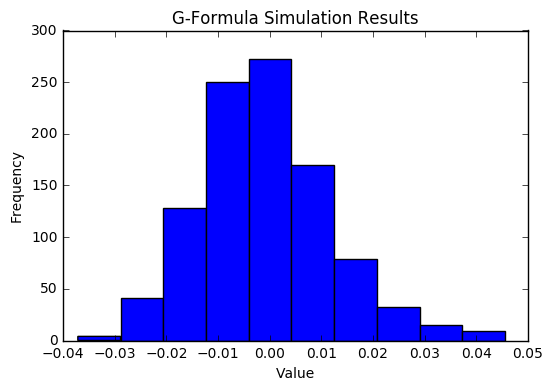

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

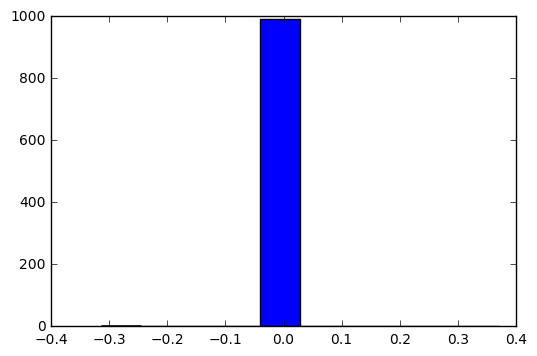

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


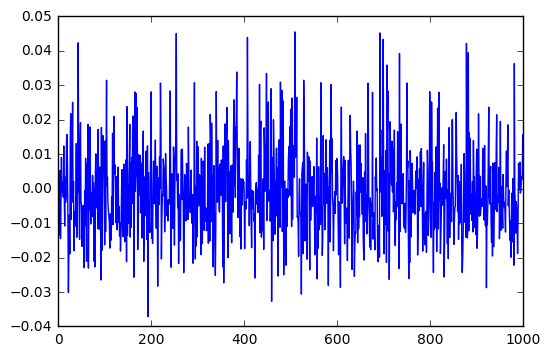

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

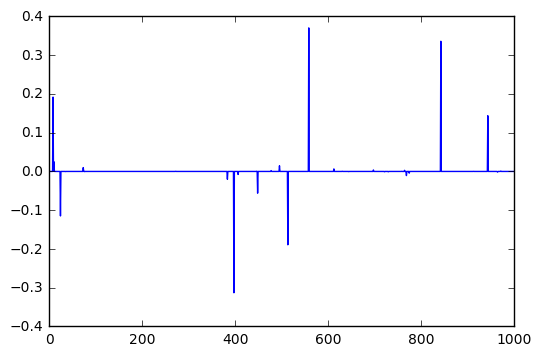

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001